In [5]:
import numpy as np
from PIL import Image
import time
from numba import cuda
import matplotlib.pyplot as plt

# Функция для загрузки изображения и преобразования в массив numpy
def load_image(filepath):
    with Image.open(filepath).convert("L") as image:
        return np.array(image, dtype=np.uint8)

# Функция для сохранения массива numpy как изображения
def save_image(image_array, filepath):
    clipped_array = np.clip(image_array, 0, 255).astype(np.uint8)
    Image.fromarray(clipped_array).save(filepath)

# CUDA-ядро для медианного фильтра
@cuda.jit
def median_filter_cuda(input_image, output_image, width, height):
    x, y = cuda.grid(2)
    if 1 <= x < width - 1 and 1 <= y < height - 1:
        window = cuda.local.array(9, dtype=np.uint8)
        idx = 0

        # Формирование окна 3x3
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                window[idx] = input_image[y + dy, x + dx]
                idx += 1

        # Сортировка окна и нахождение медианы
        for i in range(8):
            for j in range(8 - i):
                if window[j] > window[j + 1]:
                    window[j], window[j + 1] = window[j + 1], window[j]

        output_image[y, x] = window[4]

# Применение медианного фильтра с использованием CUDA
def apply_median_filter(image_array):
    height, width = image_array.shape
    output_image = np.zeros_like(image_array)

    # Передача данных на устройство
    d_input = cuda.to_device(image_array)
    d_output = cuda.to_device(output_image)

    # Настройка сетки и блоков
    threads_per_block = (16, 16)
    blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]

    # Запуск CUDA-ядра
    median_filter_cuda[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](d_input, d_output, width, height)

    # Копирование результата на хост
    return d_output.copy_to_host()

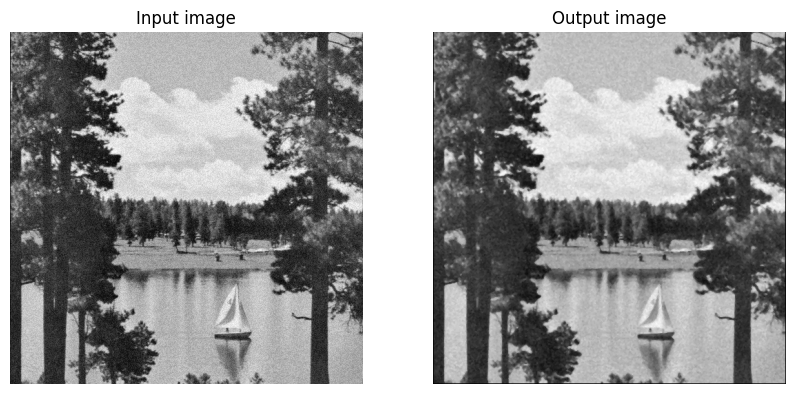

Output image save as output.bmp
Time of processing: 0.002 seconds


In [7]:
input_filepath = "input.bmp"  # Входное изображение с шумом
output_filepath = "output.bmp"  # Выходное изображение

# Загрузка изображения
image_array = load_image(input_filepath)

# Отображение входного изображения
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input image")
plt.imshow(image_array, cmap="gray")
plt.axis("off")

# Обработка изображения и измерение времени выполнения
start_time = time.time()
filtered_image = apply_median_filter(image_array)
elapsed_time = time.time() - start_time

# Отображение выходного изображения
plt.subplot(1, 2, 2)
plt.title("Output image")
plt.imshow(filtered_image, cmap="gray")
plt.axis("off")
plt.show()

# Сохранение результата
save_image(filtered_image, output_filepath)

print(f"Output image save as {output_filepath}")
print(f"Time of processing: {elapsed_time:.3f} seconds")